<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Linear_Evaluation_Imagenet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.2


In [2]:
!pip3 install tensorflow

  Using cached tensorflow-2.6.2-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached h5py-3.1.0-cp36-cp36m-manylinux1_x86_64.whl (4.0 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached clang-5.0-py3-none-any.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-non

### Restoring model weights from `wandb` run page

In [6]:
simclr_weights = "/home/selfsuper/20220905-082335resnet_simclr.h5"

In [15]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [14]:
!pip3 install imutils

  Using cached imutils-0.5.4-py3-none-any.whl


## Dataset gathering and preparation

In [16]:
# Train and test image paths
train_images_10 = list(paths.list_images("/home/Experiment_data/TRAIN/"))
test_images = list(paths.list_images("/home/Experiment_data/test/"))
print(len(train_images), len(test_images))

460 230


In [18]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [19]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 460/460 [00:06<00:00, 70.34it/s]


(460, 224, 224, 3) (460,)


100%|██████████| 230/230 [00:03<00:00, 63.89it/s]


(230, 224, 224, 3) (230,)


In [20]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [21]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [23]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights)
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [24]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [25]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [26]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [27]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(460, 128) (230, 128)


In [28]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/30
29/29 [==============================] - 0s 6ms/step - loss: 2.0489 - accuracy: 0.6565 - val_loss: 0.1603 - val_accuracy: 0.9609
Epoch 2/30
29/29 [==============================] - 0s 2ms/step - loss: 0.1182 - accuracy: 0.9739 - val_loss: 0.0091 - val_accuracy: 0.9957
Epoch 3/30
29/29 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9935 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 4/30
29/29 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/30
29/29 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/30
29/29 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 9.6198e-04 - val_accuracy: 1.0000
Epoch 7/30
29/29 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 7.6146e-04 - val_accuracy: 1.0000
Epoch 8/30
2

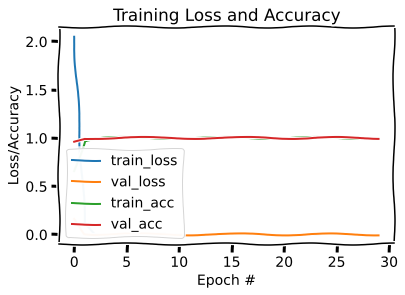

In [31]:
# Linear model

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=16,
                 epochs=30,
                 callbacks=[es])
plot_training(history)

In [32]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(460, 256) (230, 256)


Epoch 1/30
29/29 [==============================] - 0s 6ms/step - loss: 0.6163 - accuracy: 0.8130 - val_loss: 0.0374 - val_accuracy: 0.9913
Epoch 2/30
29/29 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9913
Epoch 3/30
29/29 [==============================] - 0s 2ms/step - loss: 5.6908e-04 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9913
Epoch 4/30
29/29 [==============================] - 0s 2ms/step - loss: 4.6141e-04 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9913
Epoch 5/30
29/29 [==============================] - 0s 1ms/step - loss: 4.1142e-04 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 0.9913
Epoch 6/30
29/29 [==============================] - 0s 2ms/step - loss: 3.7645e-04 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9913
Epoch 7/30
29/29 [==============================] - 0s 2ms/step - loss: 3.3328e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9913


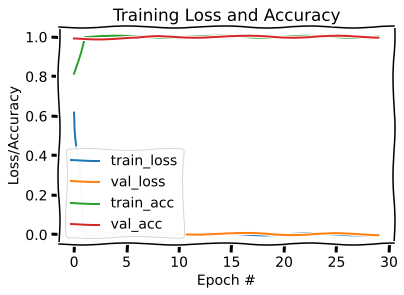

In [34]:
#wandb.init(project="simclr", id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=16,
                 epochs=30,
                 callbacks=[es])
plot_training(history)

In [35]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(460, 2048) (230, 2048)


Epoch 1/35
8/8 [==============================] - 1s 30ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 4.4056e-08 - val_accuracy: 1.0000
Epoch 2/35
8/8 [==============================] - 0s 6ms/step - loss: 7.5154e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/35
8/8 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/35
8/8 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


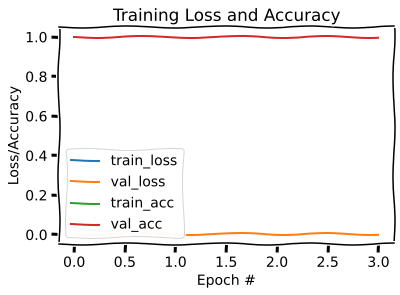

In [36]:
#wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)